In [ ]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 12.7 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import skfuzzy as fuzz

import skfuzzy.control as ctrl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
zip_path = "/content/drive/MyDrive/Dataset final.zip"  # Update if needed



In [ ]:
import zipfile
import os

extract_path = "/content/dataset"  # Folder where the dataset will be extracted
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")


Dataset extracted successfully!


In [ ]:
import os
import shutil
import random

# Define dataset path
dataset_path = "dataset/diseased"  # Change if your dataset is in a different folder
train_path = "dataset/train"
val_path = "dataset/val"

# Create train and val directories if not exist
for folder in [train_path, val_path]:
    os.makedirs(folder, exist_ok=True)

# Get all class folders (disease categories)
class_folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

# Split and move images
split_ratio = 0.8  # 80% train, 20% validation

for class_folder in class_folders:
    class_path = os.path.join(dataset_path, class_folder)
    images = os.listdir(class_path)

    # Shuffle images to randomize selection
    random.shuffle(images)

    split_idx = int(len(images) * split_ratio)
    train_images = images[:split_idx]
    val_images = images[split_idx:]

    # Create class subfolders in train and val
    os.makedirs(os.path.join(train_path, class_folder), exist_ok=True)
    os.makedirs(os.path.join(val_path, class_folder), exist_ok=True)

    # Move images to train folder
    for img in train_images:
        shutil.move(os.path.join(class_path, img), os.path.join(train_path, class_folder, img))

    # Move images to val folder
    for img in val_images:
        shutil.move(os.path.join(class_path, img), os.path.join(val_path, class_folder, img))

print("✅ Dataset successfully split into train and validation sets!")


✅ Dataset successfully split into train and validation sets!


In [ ]:
mapping = {
    "Acne and Rosacea": {
        "deficiencies": ["Vitamin A", "Zinc", "Omega-3"],
        "recommendations": "Eat carrots, spinach, nuts, and fatty fish. Avoid processed foods and dairy."
    },
    "Actinic Keratosis and other Malignant Lesions": {
        "deficiencies": ["Vitamin D", "Vitamin C", "Omega-3"],
        "recommendations": "Consume salmon, citrus fruits, and flaxseeds."
    },
    "Alopecia Areata": {
        "deficiencies": ["Vitamin D", "Biotin (B7)", "Iron"],
        "recommendations": "Include eggs, nuts, and leafy greens in your meals."
    },
    "Angular Cheilitis": {
        "deficiencies": ["Vitamin B2", "Iron", "Zinc"],
        "recommendations": "Add dairy, leafy greens, and legumes to your diet."
    },
    "Atopic Dermatitis": {
        "deficiencies": ["Vitamin D", "Omega-3", "Vitamin E"],
        "recommendations": "Eat fatty fish, nuts, and vitamin D-rich foods."
    },
    "Beau's Lines": {
        "deficiencies": ["Zinc", "Biotin (B7)", "Iron"],
        "recommendations": "Eat seeds, lentils, and eggs."
    },
    "Bluish Nail": {
        "deficiencies": ["Iron", "Vitamin D"],
        "recommendations": "Boost iron intake and get regular sunlight."
    },
    "Bullous Disease": {
        "deficiencies": ["Vitamin C", "Zinc"],
        "recommendations": "Eat citrus fruits and nuts."
    },
    "Clubbing": {
        "deficiencies": ["Vitamin D", "Iron"],
        "recommendations": "Increase intake of eggs, salmon, and lentils."
    },
    "Eczema": {
        "deficiencies": ["Vitamin D", "Omega-3", "Vitamin E"],
        "recommendations": "Consume fatty fish, sunflower seeds, and yogurt."
    },
    "Folliculitis": {
        "deficiencies": ["Zinc", "Vitamin A"],
        "recommendations": "Add pumpkin seeds, carrots, and eggs to your meals."
    },
    "Glossitis": {
        "deficiencies": ["Vitamin B12", "Iron", "Folate"],
        "recommendations": "Eat spinach, fortified cereals, and lean meats."
    },
    "healthy hair": {
        "deficiencies": ["None"],
        "recommendations": "Maintain a balanced diet and proper hair care."
    },
    "healthy nail": {
        "deficiencies": ["None"],
        "recommendations": "Ensure good nutrition and nail hygiene."
    },
    "healthy skin": {
        "deficiencies": ["None"],
        "recommendations": "Eat a variety of fruits, vegetables, and healthy fats."
    },
    "healthy tongue": {
        "deficiencies": ["None"],
        "recommendations": "Stay hydrated and eat balanced meals."
    },
    "Herpes, HPV and other STDs": {
        "deficiencies": ["Vitamin C", "Zinc"],
        "recommendations": "Consume citrus fruits and pumpkin seeds."
    },
    "Koilonychia": {
        "deficiencies": ["Iron", "Vitamin B12"],
        "recommendations": "Include red meat, legumes, and dairy."
    },
    "Leukonychia": {
        "deficiencies": ["Zinc", "Calcium"],
        "recommendations": "Eat dairy, nuts, and seeds."
    },
    "Light Diseases and Disorders of Pigmentation": {
        "deficiencies": ["Vitamin B12", "Vitamin D"],
        "recommendations": "Consume eggs, fish, and fortified dairy."
    },
    "Lupus and other Connective Tissue diseases": {
        "deficiencies": ["Vitamin D", "Omega-3"],
        "recommendations": "Add salmon and leafy greens to your diet."
    },
    "Melanoma and Moles": {
        "deficiencies": ["Vitamin D", "Vitamin A"],
        "recommendations": "Eat salmon, carrots, and sweet potatoes."
    },
    "Melanonychia": {
        "deficiencies": ["Iron", "Folate"],
        "recommendations": "Consume legumes and leafy vegetables."
    },
    "Muehrckes Lines": {
        "deficiencies": ["Protein", "Zinc"],
        "recommendations": "Eat fish, legumes, and seeds."
    },
    "Nail Psoriasis": {
        "deficiencies": ["Vitamin D", "Zinc"],
        "recommendations": "Include tuna, fortified milk, and pumpkin seeds."
    },
    "Onycholysis": {
        "deficiencies": ["Iron", "Biotin (B7)"],
        "recommendations": "Add eggs, spinach, and lentils to your meals."
    },
    "Pellagra": {
        "deficiencies": ["Niacin (Vitamin B3)"],
        "recommendations": "Eat peanuts, poultry, and whole grains."
    },
    "Perioral and Seborrheic Dermatitis": {
        "deficiencies": ["Vitamin B2", "Zinc"],
        "recommendations": "Consume yogurt, seeds, and lean meat."
    },
    "Psoriasis": {
        "deficiencies": ["Vitamin D", "Omega-3"],
        "recommendations": "Eat salmon, flaxseeds, and avoid sugary foods."
    },
    "Telogen Effluvium": {
        "deficiencies": ["Iron", "Biotin (B7)"],
        "recommendations": "Include eggs, leafy greens, and whole grains."
    },
    "Terry's Nail": {
        "deficiencies": ["Zinc", "Iron"],
        "recommendations": "Eat red meat, seafood, and nuts."
    },
    "Urticaria Hives": {
        "deficiencies": ["Vitamin C", "Zinc"],
        "recommendations": "Add oranges, green tea, and pumpkin seeds to your diet."
    }
}


In [ ]:
import os

train_dir = "dataset/train"
val_dir = "dataset/val"

print("Train Classes:", sorted(os.listdir(train_dir)))
print("Val Classes:", sorted(os.listdir(val_dir)))


Train Classes: ['Acne and Rosacea', 'Actinic Keratosis and other Malignant Lesions', 'Alopecia Areata', 'Angular Cheilitis', 'Atopic Dermatitis', "Beau's Lines", 'Bluish Nail', 'Bullous Disease', 'Clubbing', 'Eczema', 'Folliculitis', 'Glossitis', 'Herpes, HPV and other STDs', 'Koilonychia', 'Leukonychia', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma and Moles', 'Melanonychia', 'Muehrckes Lines', 'Nail Psoriasis', 'Onycholysis', 'Pellagra', 'Perioral and Seborrheic Dermatitis', 'Psoriasis', 'Telogen Effluvium', "Terry's Nail", 'Urticaria Hives', 'healthy hair', 'healthy nail', 'healthy skin', 'healthy tongue']
Val Classes: ['Acne and Rosacea', 'Actinic Keratosis and other Malignant Lesions', 'Alopecia Areata', 'Angular Cheilitis', 'Atopic Dermatitis', "Beau's Lines", 'Bluish Nail', 'Bullous Disease', 'Clubbing', 'Eczema', 'Folliculitis', 'Glossitis', 'Herpes, HPV and other STDs', 'Koilonychia', 'Leukonychia', 'Light Diseases and

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,            # more rotation
    width_shift_range=0.2,        # more horizontal shift
    height_shift_range=0.2,       # more vertical shift
    zoom_range=0.3,               # allow greater zoom
    shear_range=0.2,              # shearing for variety
    horizontal_flip=True,         # good for symmetry
    vertical_flip=True,           # useful for some skin/nail images
    brightness_range=[0.7, 1.3],  # vary lighting
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255  # No augmentation for validation
)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    'dataset/val',
    target_size=(224, 224),
    batch_size=8,
    class_mode='categorical',
    shuffle=False
)


Found 3729 images belonging to 32 classes.
Found 950 images belonging to 32 classes.


In [ ]:
train_count = len(train_generator.filenames)
val_count = len(val_generator.filenames)

print(f"Number of training images: {train_count}")
print(f"Number of validation images: {val_count}")


Number of training images: 3729
Number of validation images: 950


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_generator.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))


In [ ]:
num_classes = len(train_generator.class_indices)
print(num_classes)


32


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

# Number of output classes
num_classes = 32  # Update this based on your dataset

# Load MobileNetV2 without the top
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Unfreeze the last 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model with a small learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
callbacks = [early_stop, reduce_lr]

# Fit the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# Save model
model.save('vitamin_model_mobilenetv2.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 112s 188ms/step - accuracy: 0.0443 - loss: 3.8370 - val_accuracy: 0.1129 - val_loss: 3.3011 - learning_rate: 1.0000e-05
Epoch 2/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 70s 150ms/step - accuracy: 0.0960 - loss: 3.2692 - val_accuracy: 0.2004 - val_loss: 2.8004 - learning_rate: 1.0000e-05
Epoch 3/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step - accuracy: 0.1905 - loss: 2.8910 - val_accuracy: 0.3049 - val_loss: 2.4319 - learning_rate: 1.0000e-05
Epoch 4/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 82s 148ms/step - accuracy: 0.2460 - loss: 2.6275 - val_accuracy: 0.3692 - val_loss: 2.1549 - learning_rate: 1.0000e-05
Epoch 5/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step - accuracy: 0.3077 - loss: 2.4000 - val_accuracy: 0.4124 - val_loss: 1.9857 - learning_rate: 1.0000e-05
Epoch 6/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 70s 150ms/step - accuracy: 0.3134 - loss: 2.3011 - val_accuracy: 0.4346 - val_loss: 1.8587 - learning_rate: 1.0000e-05
Epoch 7/50
467/467 ━━━━━━━━━━━━━━━━━━━━ 70s 1

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Load the model
model = load_model("vitamin_model_mobilenetv2.keras")  # or .h5 if that's your format

# Unfreeze the last 50 layers
trainable_count = 50
for layer in model.layers[-trainable_count:]:
    layer.trainable = True

# Compile the model again with a lower learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks (optional)
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=2, factor=0.5, verbose=1),
    ModelCheckpoint("finetuned_model.keras", save_best_only=True)
]

# Fit again (fine-tuning)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 105s 179ms/step - accuracy: 0.6700 - loss: 1.0379 - val_accuracy: 0.6730 - val_loss: 1.1033 - learning_rate: 1.0000e-05
Epoch 2/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 120s 150ms/step - accuracy: 0.6674 - loss: 1.0451 - val_accuracy: 0.6751 - val_loss: 1.0926 - learning_rate: 1.0000e-05
Epoch 3/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 71s 153ms/step - accuracy: 0.6911 - loss: 0.9985 - val_accuracy: 0.6762 - val_loss: 1.0960 - learning_rate: 1.0000e-05
Epoch 4/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6853 - loss: 0.9967
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
467/467 ━━━━━━━━━━━━━━━━━━━━ 70s 149ms/step - accuracy: 0.6853 - loss: 0.9966 - val_accuracy: 0.6730 - val_loss: 1.0990 - learning_rate: 1.0000e-05
Epoch 5/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 71s 152ms/step - accuracy: 0.6962 - loss: 0.9677 - val_accuracy: 0.6688 - val_loss: 1.1043 - learning_rate: 5.0000e-06
Epoch 6/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/s

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# 1. Load your saved model
model = load_model('/content/finetuned_model.keras')  # Adjust the path to your saved model

# 2. Unfreeze the last 50 layers (or you can unfreeze more if needed)
for layer in model.layers[-50:]:
    layer.trainable = True

# Optional: If you want to unfreeze all layers for fine-tuning, uncomment below
# for layer in model.layers:
#     layer.trainable = True

# 3. Compile the model with a low learning rate (for fine-tuning)
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# 4. Resume training from the last epoch with callbacks to save the best model and prevent overfitting
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('fine_tuned_model.h5', save_best_only=True)
]

# 5. Continue training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,  # specify how many more epochs to train
    initial_epoch=7,  # Start from the 7th epoch
    callbacks=callbacks
)


Epoch 8/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6880 - loss: 0.9824

467/467 ━━━━━━━━━━━━━━━━━━━━ 103s 174ms/step - accuracy: 0.6880 - loss: 0.9824 - val_accuracy: 0.6751 - val_loss: 1.0986
Epoch 9/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.6776 - loss: 1.0100

467/467 ━━━━━━━━━━━━━━━━━━━━ 69s 148ms/step - accuracy: 0.6776 - loss: 1.0100 - val_accuracy: 0.6698 - val_loss: 1.0965
Epoch 10/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7045 - loss: 0.9387

467/467 ━━━━━━━━━━━━━━━━━━━━ 82s 148ms/step - accuracy: 0.7044 - loss: 0.9388 - val_accuracy: 0.6730 - val_loss: 1.0906
Epoch 11/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 71s 152ms/step - accuracy: 0.6797 - loss: 0.9953 - val_accuracy: 0.6677 - val_loss: 1.1111
Epoch 12/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 71s 152ms/step - accuracy: 0.6830 - loss: 0.9636 - val_accuracy: 0.6783 - val_loss: 1.0919
Epoch 13/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 72s 153ms/step - accuracy: 0.6919 - loss: 0.9552 - val_accuracy: 0.6772 - val_loss: 1.0909
Epoch 14/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 72s 154ms/step - accuracy: 0.7111 - loss: 0.9207 - val_accuracy: 0.6835 - val_loss: 1.0965
Epoch 15/20
467/467 ━━━━━━━━━━━━━━━━━━━━ 69s 148ms/step - accuracy: 0.7068 - loss: 0.9218 - val_accuracy: 0.6804 - val_loss: 1.1070


In [ ]:
# Get predictions on validation set
predictions = model.predict(val_generator, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


119/119 ━━━━━━━━━━━━━━━━━━━━ 52s 418ms/step


In [ ]:
import numpy as np

# Assume `predictions` is model.predict() output: shape (N, 38)
confidences = np.max(predictions, axis=1)
top2_diffs = np.sort(predictions, axis=1)[:, -1] - np.sort(predictions, axis=1)[:, -2]


In [ ]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Define fuzzy input variables
confidence = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'confidence')
top2_gap = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'top2_gap')
decision = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'decision')  # 0 = reject, 1 = accept

# Define fuzzy sets
confidence['low'] = fuzz.trimf(confidence.universe, [0, 0, 0.4])
confidence['medium'] = fuzz.trimf(confidence.universe, [0.3, 0.5, 0.7])
confidence['high'] = fuzz.trimf(confidence.universe, [0.6, 1, 1])

top2_gap['small'] = fuzz.trimf(top2_gap.universe, [0, 0, 0.3])
top2_gap['medium'] = fuzz.trimf(top2_gap.universe, [0.2, 0.5, 0.8])
top2_gap['large'] = fuzz.trimf(top2_gap.universe, [0.7, 1, 1])

decision['reject'] = fuzz.trimf(decision.universe, [0, 0, 0.5])
decision['maybe'] = fuzz.trimf(decision.universe, [0.3, 0.5, 0.7])
decision['accept'] = fuzz.trimf(decision.universe, [0.6, 1, 1])


In [ ]:
rule1 = ctrl.Rule(confidence['high'] & top2_gap['large'], decision['accept'])
rule2 = ctrl.Rule(confidence['medium'] & top2_gap['medium'], decision['maybe'])
rule3 = ctrl.Rule(confidence['low'] | top2_gap['small'], decision['reject'])

decision_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
fuzzy_decision = ctrl.ControlSystemSimulation(decision_ctrl)


In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# Define input variables
confidence = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'confidence')
top2_gap = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'top2_gap')

# Define output variable
decision = ctrl.Consequent(np.arange(0, 1.01, 0.01), 'decision')

# Membership functions for confidence
confidence['low'] = fuzz.trimf(confidence.universe, [0, 0, 0.5])
confidence['medium'] = fuzz.trimf(confidence.universe, [0.3, 0.5, 0.7])
confidence['high'] = fuzz.trimf(confidence.universe, [0.5, 1.0, 1.0])

# Membership functions for top2_gap
top2_gap['small'] = fuzz.trimf(top2_gap.universe, [0, 0, 0.3])
top2_gap['medium'] = fuzz.trimf(top2_gap.universe, [0.2, 0.5, 0.8])
top2_gap['large'] = fuzz.trimf(top2_gap.universe, [0.6, 1.0, 1.0])

# Membership functions for decision
decision['unsure'] = fuzz.trimf(decision.universe, [0, 0, 0.4])
decision['maybe'] = fuzz.trimf(decision.universe, [0.3, 0.5, 0.7])
decision['confident'] = fuzz.trimf(decision.universe, [0.6, 1.0, 1.0])

# Rules
rule1 = ctrl.Rule(confidence['high'] & top2_gap['large'], decision['confident'])
rule2 = ctrl.Rule(confidence['medium'] | top2_gap['medium'], decision['maybe'])
rule3 = ctrl.Rule(confidence['low'] & top2_gap['small'], decision['unsure'])

# Control system
decision_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
fuzzy_decision = ctrl.ControlSystemSimulation(decision_ctrl)


In [ ]:
results = []
for conf, gap in zip(confidences, top2_diffs):
    fuzzy_decision.input['confidence'] = conf
    fuzzy_decision.input['top2_gap'] = gap
    fuzzy_decision.compute()
    results.append(fuzzy_decision.output['decision'])  # ✅ this will now work


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Keep your model, mapping, and class_labels loaded as you have already

def predict_vitamin_deficiency(img_path):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    preds = model.predict(img_array)
    class_idx = np.argmax(preds)
    class_name = class_labels[class_idx]
    confidence = preds[0][class_idx]

    # Get deficiency info
    info = mapping.get(class_name, {
        "deficiencies": ["Unknown"],
        "recommendations": "No recommendation available."
    })
    deficiencies = info["deficiencies"]
    recommendations = info["recommendations"]

    # Display predictions
    print(f"Predicted Class: {class_name}")
    print(f"Confidence: {confidence:.2f}")
    print(f"Possible Vitamin Deficiencies: {', '.join(deficiencies)}")
    print(f"Dietary/Health Recommendations: {recommendations}")

    # Show image inline
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{class_name} ({confidence*100:.2f}%)")
    plt.show()


In [ ]:
print("Class Labels:", class_labels)


Class Labels: {0: 'Acne and Rosacea', 1: 'Actinic Keratosis and other Malignant Lesions', 2: 'Alopecia Areata', 3: 'Angular Cheilitis', 4: 'Atopic Dermatitis', 5: "Beau's Lines", 6: 'Bluish Nail', 7: 'Bullous Disease', 8: 'Clubbing', 9: 'Eczema', 10: 'Folliculitis', 11: 'Glossitis', 12: 'Herpes, HPV and other STDs', 13: 'Koilonychia', 14: 'Leukonychia', 15: 'Light Diseases and Disorders of Pigmentation', 16: 'Lupus and other Connective Tissue diseases', 17: 'Melanoma and Moles', 18: 'Melanonychia', 19: 'Muehrckes Lines', 20: 'Nail Psoriasis', 21: 'Onycholysis', 22: 'Pellagra', 23: 'Perioral and Seborrheic Dermatitis', 24: 'Psoriasis', 25: 'Telogen Effluvium', 26: "Terry's Nail", 27: 'Urticaria Hives', 28: 'healthy hair', 29: 'healthy nail', 30: 'healthy skin', 31: 'healthy tongue'}


In [ ]:
print("Mapping Dictionary:", mapping)


Mapping Dictionary: {'class_1': {'deficiencies': ['Vitamin A'], 'recommendations': 'Increase vitamin A intake through carrots, spinach.'}, 'class_2': {'deficiencies': ['Vitamin C'], 'recommendations': 'Consume more citrus fruits, bell peppers.'}}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Predicted Class: Bullous Disease
Confidence: 0.76
Possible Vitamin Deficiencies: Vitamin C, Zinc
Dietary/Health Recommendations: Eat citrus fruits and nuts.


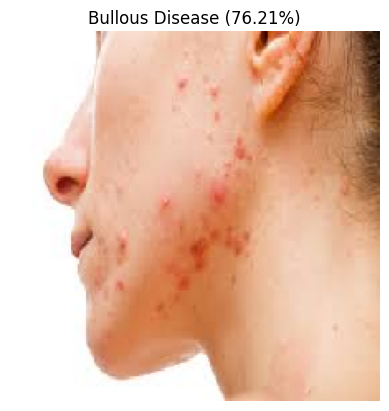

In [ ]:
predict_vitamin_deficiency('test1.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted Class: Koilonychia
Confidence: 0.41
Possible Vitamin Deficiencies: Iron, Vitamin B12
Dietary/Health Recommendations: Include red meat, legumes, and dairy.


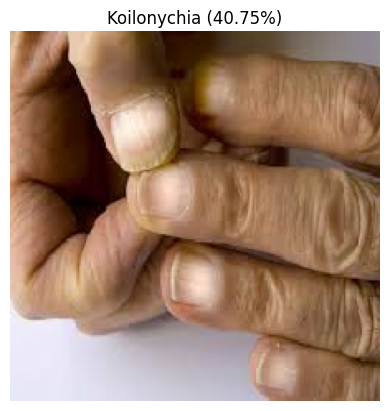

In [ ]:
predict_vitamin_deficiency('test2.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Class: Alopecia Areata
Confidence: 1.00
Possible Vitamin Deficiencies: Vitamin D, Biotin (B7), Iron
Dietary/Health Recommendations: Include eggs, nuts, and leafy greens in your meals.


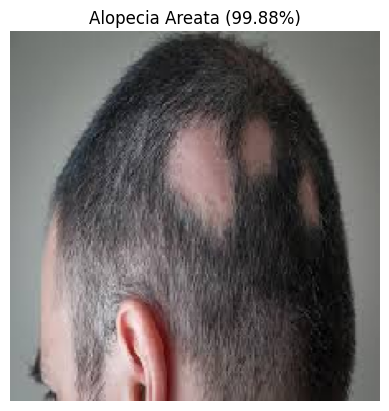

In [ ]:
predict_vitamin_deficiency('test3.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Predicted Class: Koilonychia
Confidence: 0.99
Possible Vitamin Deficiencies: Iron, Vitamin B12
Dietary/Health Recommendations: Include red meat, legumes, and dairy.


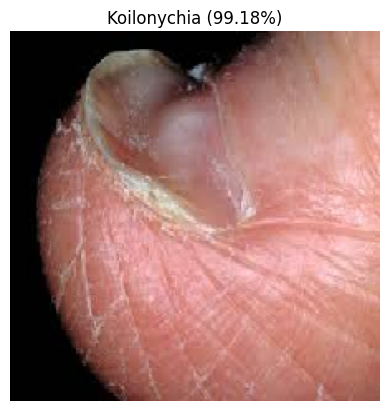

In [ ]:
predict_vitamin_deficiency('test5.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
Predicted Class: Pellagra
Confidence: 0.92
Possible Vitamin Deficiencies: Niacin (Vitamin B3)
Dietary/Health Recommendations: Eat peanuts, poultry, and whole grains.


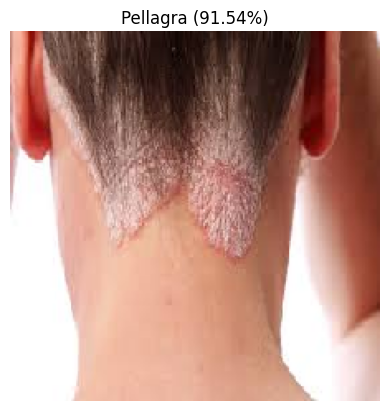

In [ ]:
predict_vitamin_deficiency('test6.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Predicted Class: Glossitis
Confidence: 0.89
Possible Vitamin Deficiencies: Vitamin B12, Iron, Folate
Dietary/Health Recommendations: Eat spinach, fortified cereals, and lean meats.


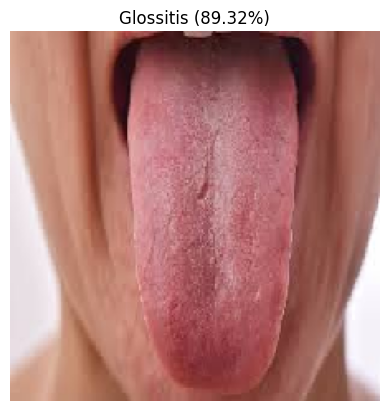

In [ ]:
predict_vitamin_deficiency('test8.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
Predicted Class: healthy skin
Confidence: 0.85
Possible Vitamin Deficiencies: None
Dietary/Health Recommendations: Eat a variety of fruits, vegetables, and healthy fats.


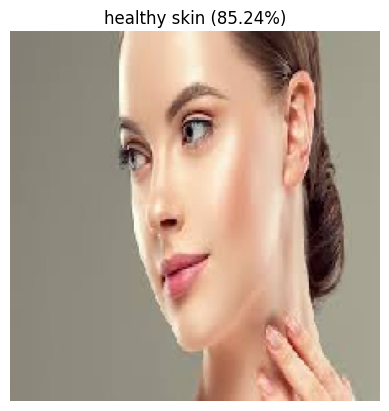

In [ ]:
predict_vitamin_deficiency('test9.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted Class: Acne and Rosacea
Confidence: 0.50
Possible Vitamin Deficiencies: Vitamin A, Zinc, Omega-3
Dietary/Health Recommendations: Eat carrots, spinach, nuts, and fatty fish. Avoid processed foods and dairy.


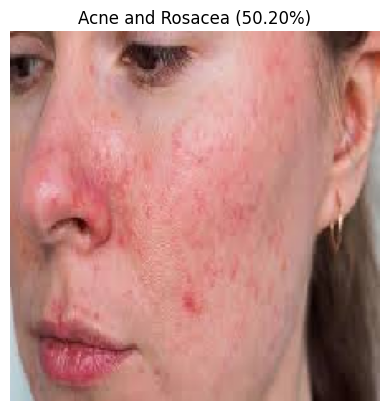

In [ ]:
predict_vitamin_deficiency('TEST.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted Class: Pellagra
Confidence: 0.96
Possible Vitamin Deficiencies: Niacin (Vitamin B3)
Dietary/Health Recommendations: Eat peanuts, poultry, and whole grains.


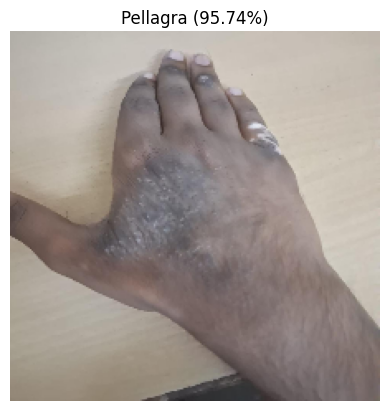

In [ ]:
predict_vitamin_deficiency('test113.jpg')

In [ ]:
# Evaluate model on validation data
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"\n✅ Validation Accuracy: {val_accuracy * 100:.2f}%")

119/119 ━━━━━━━━━━━━━━━━━━━━ 52s 399ms/step - accuracy: 0.7040 - loss: 0.8784

✅ Validation Accuracy: 78.63%
